# **Ask ChatGPT for One-Shot Mathematical Definitum Extraction**

In [38]:
#!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.9/266.9 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 18.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline, AutoModelForTokenClassification, get_cosine_schedule_with_warmup, AutoTokenizer
from seqeval.metrics import classification_report
import seaborn as sns
import os
import openai
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


## Preprocessing the dataset

Preliminary test shows that ChatGPT generated random IOB tags might not be aligned with the extracted terms.
We decide to ask for the terms only. We evaluate later the precision (how many extracted terms are true) and recall(how many expected terms are extracted).

In [2]:
df = pd.read_csv("cleaned_plain-text_labeled_term+combined_no_ref_no_cit_def_same_len_only_must_conatin_B.csv", delimiter=',')
len(df)

13692

In [3]:
all_texts = df['plain_text_def'].to_list()
#check average tokenized sentence lenth
all_text_lenlist = [len(e.split(' ')) for e in all_texts]
print("average length = ", sum(all_text_lenlist) / len(all_text_lenlist))
print("maximun length = ", max(all_text_lenlist))

average length =  70.69770669003798
maximun length =  5266


In [4]:
df['text_token_num']=all_text_lenlist

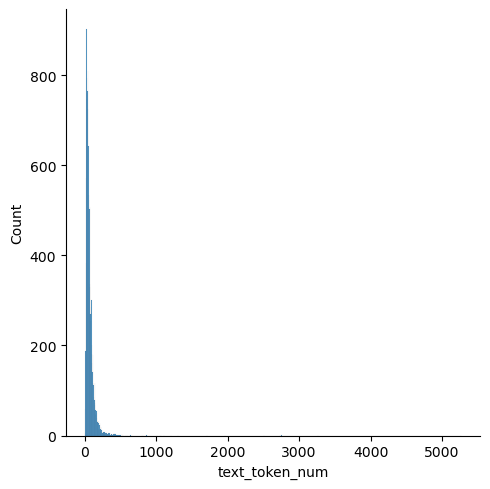

In [15]:
#check length distribution
sns_dis = sns.displot(df['text_token_num'])
sns_dis.savefig('all_text_len_dist.pdf')

In [16]:
df499 = df[df['text_token_num'] <= 500]
len(df499)

13653

In [11]:
df499.to_csv('cleaned_plain-text_labeled_term+combined_no_ref_no_cit_def_same_len_only_must_conatin_B_less_than_500tokens.csv', index=False)

In [12]:
print("average length = ", sum(df499['text_token_num']) / len(df499['text_token_num']))
print("maximun length = ", max(df499['text_token_num']))

average length =  67.62455138064894
maximun length =  497


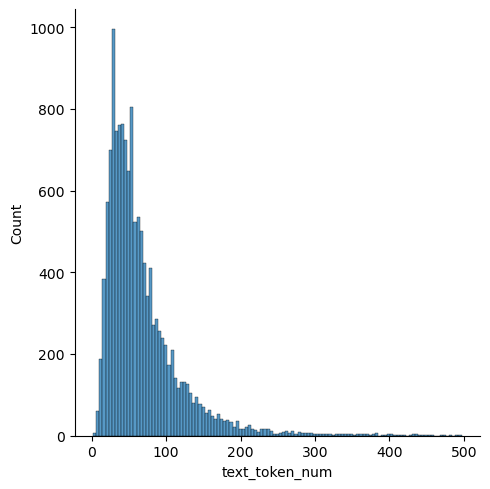

In [14]:
sns_dis_499 = sns.displot(df499['text_token_num'])
sns_dis_499.savefig('text499_len_dist.pdf')

In [18]:
gen_data = df499[['plain_text_def','plain_text_term']].copy()

In [19]:
gen_data = gen_data[-1024:]
#gen_data.to_csv('data/test_GPT.csv', index=False)

In [20]:
gen_texts = gen_data['plain_text_def'].to_list()
#check average tokenized sentence lenth
gen_text_lenlist = [len(e.split(' ')) for e in gen_texts]
print("average length = ", sum(gen_text_lenlist) / len(gen_text_lenlist))
print("maximun length = ", max(gen_text_lenlist))

average length =  69.6083984375
maximun length =  418


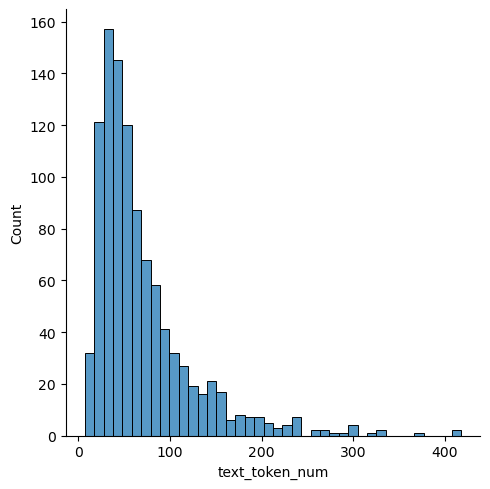

In [21]:
#check length distribution
gen_data['text_token_num'] = gen_text_lenlist
sns_dis_gen = sns.displot(gen_data['text_token_num'])
sns_dis_gen.savefig('text_gen_len_dist.pdf')

## Ask ChatGPT-3.5


In [ ]:
openai.api_key_path="API_KEY/TheoremKB_Shufan.txt"

In [30]:
gen_data = pd.read_csv('data/test_GPT.csv')

In [23]:
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
    {
      "role": "system",
      "content": "You will be provided with a block of text that might define one or multiple mathematical terms. Your task is to extract the defined term(s).  For example, the phrase “An interval of _n is called new if it cannot be obtained as the grafting of two intervals” defines “new”. It is possible that the sentence does not contain the defined term. You should only return me the terms that you find, separate the terms with ###.Please do not print anything else."
    },
    {
      "role": "user",
      "content": "Given a word w let v be the letters of w to which the\nthrough strings of the unique w-admissible half-pairing\nare attached. Then v is a cyclic reduction of w – we\nshall call it the standard cyclic reduction of w\nand denote it w.\n"
    }
    ],
    temperature=0,
    max_tokens=128,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)

In [24]:
response

<OpenAIObject chat.completion id=chatcmpl-7s0fDMpRPIaPCSPcmLQvCjVsrtcpv at 0x7f41304b9ae0> JSON: {
  "id": "chatcmpl-7s0fDMpRPIaPCSPcmLQvCjVsrtcpv",
  "object": "chat.completion",
  "created": 1693106619,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "cyclic reduction###standard cyclic reduction"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 165,
    "completion_tokens": 7,
    "total_tokens": 172
  }
}

In [20]:
response.to_dict()["choices"][0]["message"]["content"]

'cyclic reduction###standard cyclic reduction'

In [48]:
previous_res = pd.read_csv("GPT_results/res.csv")
previous_terms_string_list = previous_res['gpt-3.5-turbo terms'].tolist()

In [49]:
previous_terms_string_list

['G-poset###compatibility graph###C_P###vertex set###adjacent###element###comparable###G',
 'G-poset###strong compatibility graph###C_P###vertex set###adjacent###element###comparable###e###y###[x]',
 'good pair###bad pair',
 'multiplicative###probability measures###partitions###sequence###positive numbers###counts###mutually independent###convex combination',
 'ergodic###limit shape of partitions',
 'simplicial map###simplicial complexes###vertices###simplex###nondegenerate###injective',
 'minimal###nondegenerate###locally k-large',
 't-uniform###minimal filling diagram###interior vertex###neighbours',
 'triangulation###holes###planar double edge###face###edge###disc###cutting along###contains',
 'NOA(n,d)###v_1###v_2###v_3###[n]###orthogonal array###symbols###column###array###ℕ',
 'exceptional interval-poset###Hasse diagram###configuration###y###z###x',
 'new###']

In [112]:
#terms_string_list = previous_terms_string_list
terms_string_list = [] #when start from zero

In [113]:
%%time
for def_txt in gen_data['plain_text_def'].tolist():
    user_obj = {
      "role": "user",
      "content": def_txt
    }
    terms_string=""
    response = openai.ChatCompletion.create(
        model="gpt-4",#"gpt-3.5-turbo",
        messages=[
        {
          "role": "system",
          "content": "You will be provided with a block of text that might define one or multiple mathematical terms. Your task is to extract the defined term(s).  For example, the phrase “An interval of _n is called new if it cannot be obtained as the grafting of two intervals” defines “new”. It is possible that the sentence does not contain the defined term. You should only return me the terms that you find, separate the terms with ###.Please do not print anything else."},
        user_obj
        ],
        temperature=0,
        max_tokens=128,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    terms_string = response.to_dict()["choices"][0]["message"]["content"]
    terms_string_list.append(terms_string)

CPU times: user 5.59 s, sys: 237 ms, total: 5.83 s
Wall time: 29min 36s


In [114]:
df_res = pd.DataFrame(terms_string_list,columns =['gpt-4 terms'])

In [115]:
df_res.to_csv("GPT_results/gpt-4_res.csv", index=False)

In [67]:
70*1024*0.0035/1000 # prix éstimé pour gpt-3.5-turbo

0.25088

In [68]:
70*1024*0.09/1000

6.4512

In [70]:
70*1024*0.09/1000 * 0.40 / 0.25 # prix éstimé pour GPT-4

10.32192

## Calculate the precision and Recall of ChatGPT's annotation

In [116]:
gen_data['gpt-4 terms'] = df_res['gpt-4 terms']
gen_data

,plain_text_def,plain_text_term,gpt-3.5-turbo terms,gpt-4 terms
0,Let P be a G-poset. The compatibility graph of...,Compatibility graph,G-poset###compatibility graph###C_P###vertex s...,compatibility graph
1,Let P be a G-poset. The strong compatibility g...,Strong compatibility graph,G-poset###strong compatibility graph###C_P###v...,strong compatibility graph
2,\nLet p=p_1p_2⋯ p_n be a permutation. \nWe say...,good pair;bad pair,good pair###bad pair,good pair###bad pair
3,\nThe family of probability measures on partit...,multiplicative,multiplicative###probability measures###partit...,multiplicative
4,\nWe call a family of measures μ^(n) ergodic i...,ergodic;limit shape,ergodic###limit shape of partitions,ergodic###limit shape of partitions
...,...,...,...,...
1019,"Consider ⟨ G→ S, α→ A⟩, two adjacent vertices...",preferred direction;special claw corresponding...,special claw###subdivided medial graph,special claw
1020,"\nAccording to Theorem <ref>, ^d has exactly d...",Cyclicity classes,cyclicity classes###,cyclicity classes
1021,By Wielandt number we mean the following funct...,Wielandt number,Wielandt number###,Wielandt number
1022,"\nThe girth of , denoted it by g(),\nis the sm...",Girth,girth###nonempty cycle,girth


In [117]:
eval_list = []
for index, row in gen_data.iterrows():

    #let's remove repeated terms in both lists, as our definitum detection requires high recall
    expected_set = set(row['plain_text_term'].split(';'))
    if '' in expected_set:
        expected_set.remove('')
    
    extracted_set = set(row['gpt-4 terms'].split('###'))
    if '' in extracted_set:
        extracted_set.remove('')
    
    num_TP = 0
    num_too_long = 0
    num_cut_off = 0
    for expected in expected_set:
        for extracted in extracted_set:
            if extracted.casefold() == expected.casefold():
                num_TP = num_TP + 1
            elif extracted.casefold() in expected.casefold():
                num_cut_off = num_cut_off + 1
            elif expected.casefold() in extracted.casefold():
                num_too_long = num_too_long + 1
    
    eval_list.append({'True Term Num' : len(expected_set),
                        'Extracted Term Num': len(extracted_set),
                        'TP': num_TP,
                        'Cut Off': num_cut_off,
                        'Too Long': num_too_long})

In [119]:
df_eval = pd.DataFrame(eval_list)
df_eval

,True Term Num,Extracted Term Num,TP,Cut Off,Too Long
0,1,1,1,0,0
1,1,1,1,0,0
2,2,2,2,0,0
3,1,1,1,0,0
4,2,2,1,0,1
...,...,...,...,...,...
1019,2,1,0,1,0
1020,1,1,1,0,0
1021,1,1,1,0,0
1022,1,1,1,0,0


In [120]:
df_eval['TP'].sum()

846

In [121]:
df_eval['True Term Num'].sum()

1616

In [122]:
df_eval['Extracted Term Num'].sum() 

2245

In [123]:
# precision /correct rate
846 / 2245

0.37683741648106905

In [124]:
# recall
846 / 1616

0.5235148514851485

In [125]:
# too long rate 
df_eval['Too Long'].sum() / 2245

0.30779510022271717

In [126]:
# cut off rate 
df_eval['Cut Off'].sum() / 2245

0.055233853006681516

In [127]:
pd.concat([gen_data, df_eval], axis=1).to_csv('GPT_results/gpt-4_res+eval.csv', index=False)

## Correct eval

In [5]:
#df_res = pd.read_csv('GPT_results/gpt-4_res+eval.csv')
df_res = pd.read_csv('GPT_results/Human_corrected_annotations+gpt_res.csv')

eval_list =[]

for index, row in df_res.iterrows():

    #let's remove repeated terms, keeping 1616 unique out of 1660 terms
    expected_list = set(row['plain_text_term'].split(';'))
    while '' in expected_list:
        expected_list.remove('')

    extracted_string = row['gpt-4 terms']#['gpt-3.5-turbo terms']
    if extracted_string != extracted_string: #nan
        extracted_list = []
    else:
        extracted_list = extracted_string.split('###')
        extracted_list = [x.strip() for x in extracted_list] 
        while '' in extracted_list:
            extracted_list.remove('')
    
    num_TP = 0
    num_too_long = 0
    num_cut_off = 0
    num_split_term = 0
    TP_list = []
    ST_list = [] 
    
    for expected in expected_list:
        for extracted in extracted_list:
            
            if extracted.casefold() == expected.casefold():
                num_TP = num_TP + 1
                TP_list.append(expected)
            elif extracted.casefold() in expected.casefold():
                num_cut_off = num_cut_off + 1
            elif expected.casefold() in extracted.casefold():
                num_too_long = num_too_long + 1
                
        expected_no_space = expected.replace(" ","")
        extracted_no_space = ("".join(extracted_list)).replace(" ","")
        if expected_no_space.casefold() in extracted_no_space.casefold(): # including TPs
            num_split_term = num_split_term + 1
            ST_list.append(expected)
    
    num_TP = num_TP - (len(TP_list) - len(set(TP_list)))
    num_split_term = num_split_term - (len(ST_list) -len(set(ST_list)))
    
    eval_list.append({'True Term Num' : len(expected_list),
                        'Extracted Term Num': len(extracted_list),
                        'TP': num_TP,
                        'Cut Off': num_cut_off,
                        'Too Long': num_too_long,
                        'Split Term': num_split_term})
df_eval = pd.DataFrame(eval_list)
df_eval['expected'] = df_res['plain_text_term']
df_eval['extracted'] = df_res['gpt-4 terms']

df_eval.to_csv('GPT_results/gpt-3.5-turbo_res+eval+ST_corrected.csv', index=False)
#df_eval.to_csv('GPT_results/gpt-3.5-turbo_res+eval+ST.csv', index=False)

In [3]:
df_res

,plain_text_def,plain_text_term,gpt-3.5-turbo terms,gpt-4 terms
0,Let P be a G-poset. The compatibility graph of...,Compatibility graph,G-poset###compatibility graph###C_P###vertex s...,compatibility graph
1,Let P be a G-poset. The strong compatibility g...,Strong compatibility graph,G-poset###strong compatibility graph###C_P###v...,strong compatibility graph
2,\nLet p=p_1p_2⋯ p_n be a permutation. \nWe say...,good pair;bad pair,good pair###bad pair,good pair###bad pair
3,\nThe family of probability measures on partit...,multiplicative,multiplicative###probability measures###partit...,multiplicative
4,\nWe call a family of measures μ^(n) ergodic i...,ergodic;limit shape,ergodic###limit shape of partitions,ergodic###limit shape of partitions
...,...,...,...,...
994,"Consider ⟨ G→ S, α→ A⟩, two adjacent vertices...",preferred direction;special claw corresponding...,special claw###subdivided medial graph,special claw
995,"\nAccording to Theorem <ref>, ^d has exactly d...",Cyclicity classes,cyclicity classes###,cyclicity classes
996,By Wielandt number we mean the following funct...,Wielandt number,Wielandt number###,Wielandt number
997,"\nThe girth of , denoted it by g(),\nis the sm...",Girth,girth###nonempty cycle,girth


### GPT4

In [6]:
num_T = df_eval['True Term Num'].sum()
print("True Term Num: " + str(num_T))
num_Ex = df_eval['Extracted Term Num'].sum()
print("Extracted Term Num: " + str(num_Ex))
print("True Positive: " + str(df_eval['TP'].sum()))
num_ST = df_eval['Split Term'].sum()
print("True Positive + split term: " + str(num_ST))
print("Too Long: " + str(df_eval['Too Long'].sum()))
print("Cut Off: " + str(df_eval['Cut Off'].sum()))
print("precision /correct rate: " + str(num_ST / num_Ex))
print("recall: " + str(num_ST / num_T))

True Term Num: 1552
Extracted Term Num: 2191
True Positive: 945
True Positive + split term: 1369
Too Long: 573
Cut Off: 137
precision /correct rate: 0.6248288452761296
recall: 0.8820876288659794


In [1]:
# GPT-4
p = 0.6248288452761296
r = 0.8820876288659794
2 * p * r / (p + r)

0.7314987977558107

### GPT3.5-turbo

In [4]:
num_T = df_eval['True Term Num'].sum()
print("True Term Num: " + str(num_T))
num_Ex = df_eval['Extracted Term Num'].sum()
print("Extracted Term Num: " + str(num_Ex))
print("True Positive: " + str(df_eval['TP'].sum()))
num_ST = df_eval['Split Term'].sum()
print("True Positive + split term: " + str(num_ST))
print("Too Long: " + str(df_eval['Too Long'].sum()))
print("Cut Off: " + str(df_eval['Cut Off'].sum()))
print("precision /correct rate: " + str(num_ST / num_Ex))
print("recall: " + str(num_ST / num_T))

True Term Num: 1552
Extracted Term Num: 6687
True Positive: 1071
True Positive + split term: 1290
Too Long: 338
Cut Off: 653
precision /correct rate: 0.19291161956034095
recall: 0.8311855670103093


In [7]:
# GPT-3.5
p = 0.19291161956034095
r = 0.8311855670103093
2 * p * r / (p + r)

0.31314479912610754